In [28]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import classifiers.classifier as classifier
import seaborn as sns
import standard_sequences.rabi_tomo as tomo
import standard_sequences.reg_tomo as reg_tomo

In [29]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(readout_dict['RO_LO'],power_dBm=readout_dict['RO_LO_pwr'], bnc_addr=bnc_address['target_bnc_black'])
bnc.set_bnc_output(general_vals_dict['TWPA_freq'], general_vals_dict['TWPA_pwr'], bnc_addr=bnc_address['big_agilent'])

Qubit(ge_amp=0.8, ro_amp=1, IQ_angle=205, qubit_id=q1, ge_ssm=-0.1145, ro_dur=4000, ef_time=49.13671850689116, RO_LO_pwr=16, ge_time=81.17534608287957, ro_freq=6.72745, ef_amp=1.5, RO_LO=6.6247, ROIF=0.10275000000000034, RO_IF=None, qubit_thr=[-10000, -600], ef_ssm=-0.2568)
Qubit(ge_amp=0.8, ro_amp=1.5, IQ_angle=85, qubit_id=q2, ge_ssm=-0.154, ro_dur=4000, ef_time=None, RO_LO_pwr=16, ge_time=45.047198597262124, ro_freq=6.6556, ef_amp=1, RO_LO=6.6247, ROIF=0.030899999999999928, RO_IF=None, qubit_thr=[-10000, 1900], ef_ssm=-0.2962)


In [3]:
def run_rabi_tomo(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    J: float
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    tomo.rabi_ef_swap_tomo(q1, q2, general_vals_dict, num_steps = num_steps, sweep_time = sweep_time, swap_freq = swap_freq , swap_time= swap_time, drive_amp_J = J, tomo_comp = tomography)

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values

In [26]:
reps = 1000
sweep_time = 2000
swap_freq= -.0195
swap_time=0.5*6/abs(swap_freq)
J = 0.1
tomography = 'y'
df_prob, df_pop, values = run_rabi_tomo(
    q1,
    q2,
    general_vals_dict,
    num_steps=100,
    sweep_time=sweep_time,
    swap_freq=swap_freq,
    swap_time=swap_time,
    reps=reps,
    tomography=tomography,
    J=J
)

0, No error
0, No error
0, No error
Patterns: 100
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 12.617790 sec
Captured 33 buffers (2.615355 buffers per sec)
Captured 101376 records (8034.370530 records per sec)
Transferred 1660944384 bytes (131635126.764604 bytes per sec)


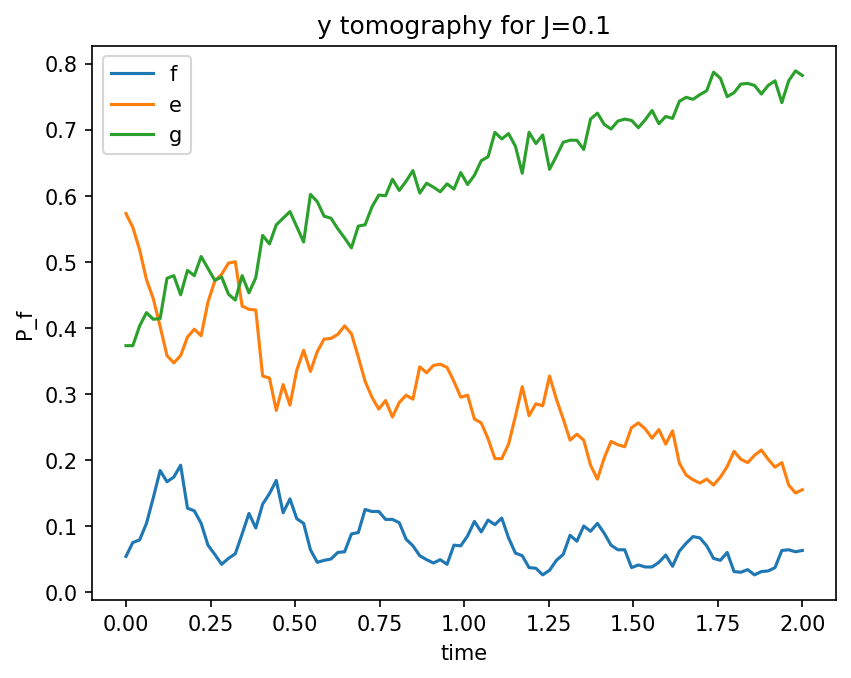

In [27]:
plt.figure(dpi =150)
sns.lineplot(data=df_prob, x="time", y="P_f", label="f")
sns.lineplot(data=df_prob, x="time", y="P_e", label="e")
sns.lineplot(data=df_prob, x="time", y="P_g", label="g")
plt.title(f'{tomography} tomography for J={J}')
plt.legend()
plt.show()